Decision Tree Metrics:
            Metric  Before CV  After CV
0         Accuracy   0.870968  0.966975
1  Precision (YES)   0.000000  1.000000
2   Precision (NO)   0.000000  0.938807
3     Recall (YES)   0.000000  0.933998
4      Recall (NO)   0.000000  1.000000
5   F1-score (YES)   0.000000  0.965609
6    F1-score (NO)   0.000000  0.968228

Random Forest Metrics:
            Metric  Before CV  After CV
0         Accuracy   0.903226  0.983445
1  Precision (YES)   0.000000  1.000000
2   Precision (NO)   0.000000  0.968485
3     Recall (YES)   0.000000  0.966888
4      Recall (NO)   0.000000  1.000000
5   F1-score (YES)   0.000000  0.983011
6    F1-score (NO)   0.000000  0.983855

Neural Network Metrics:
            Metric  Before CV  After CV
0         Accuracy   0.903226  0.747619
1  Precision (YES)   0.000000  0.734176
2   Precision (NO)   0.000000  0.766087
3     Recall (YES)   0.000000  0.777852
4      Recall (NO)   0.000000  0.716833
5   F1-score (YES)   0.000000  0.754252
6    F1-

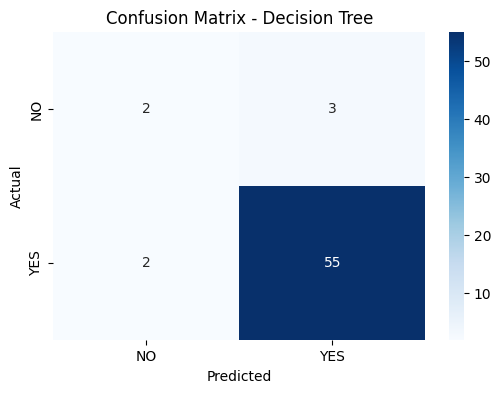

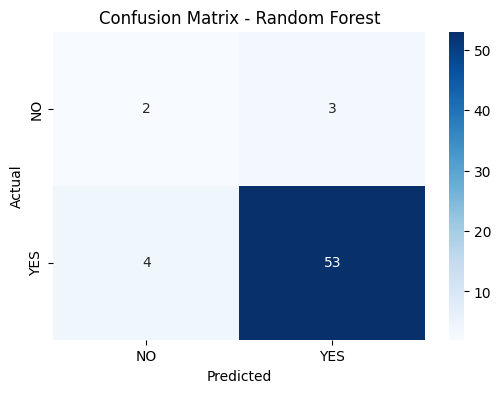

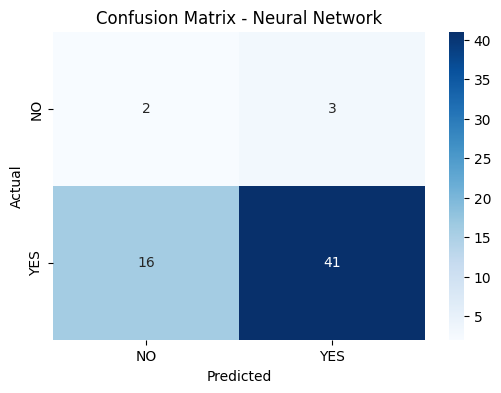

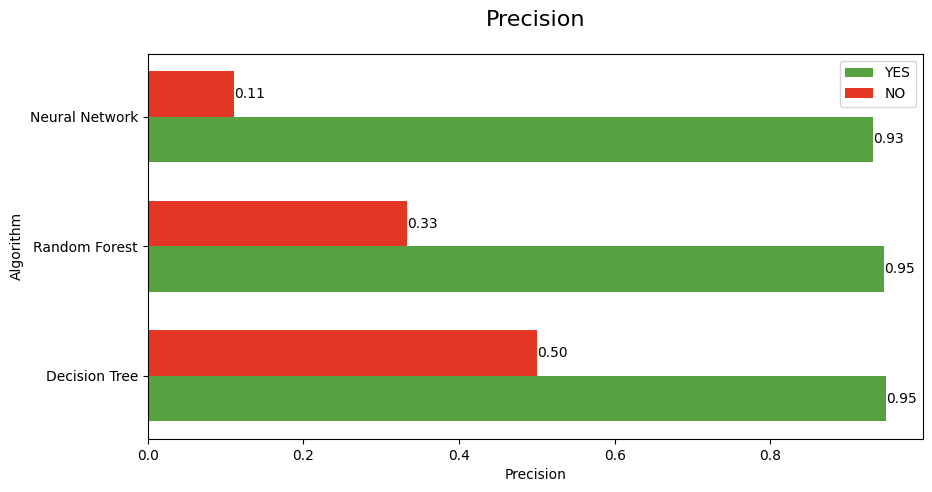

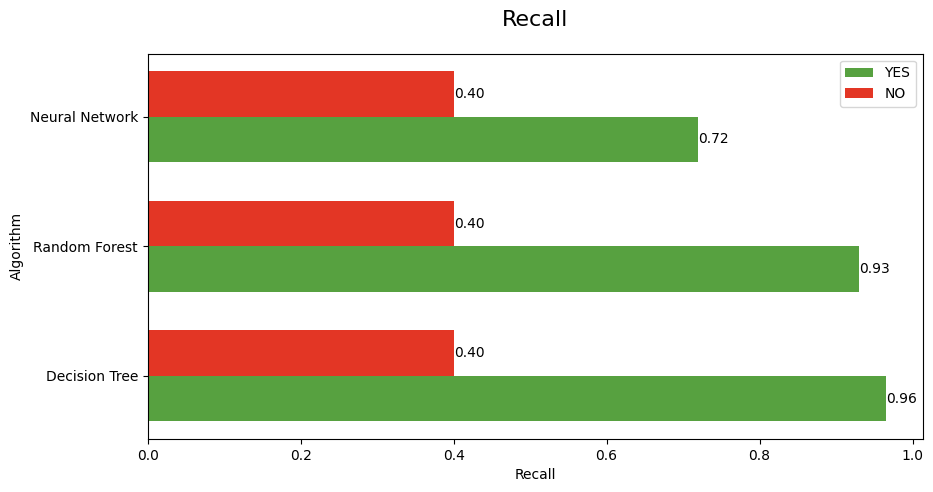

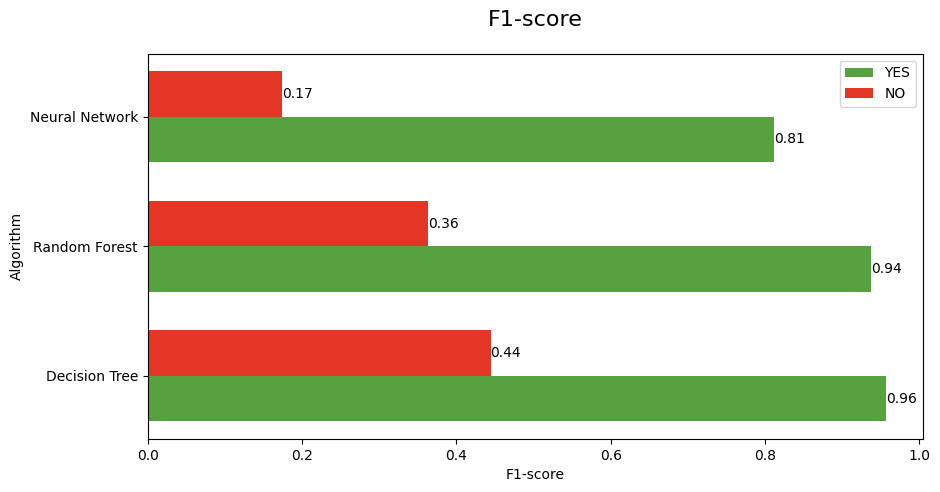

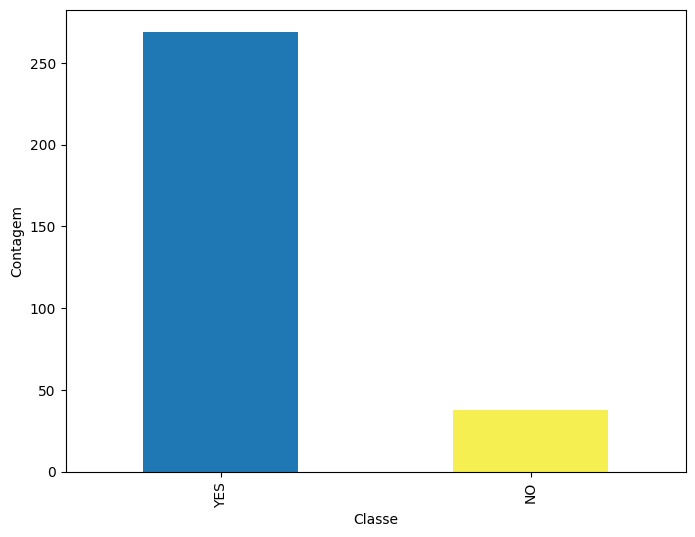

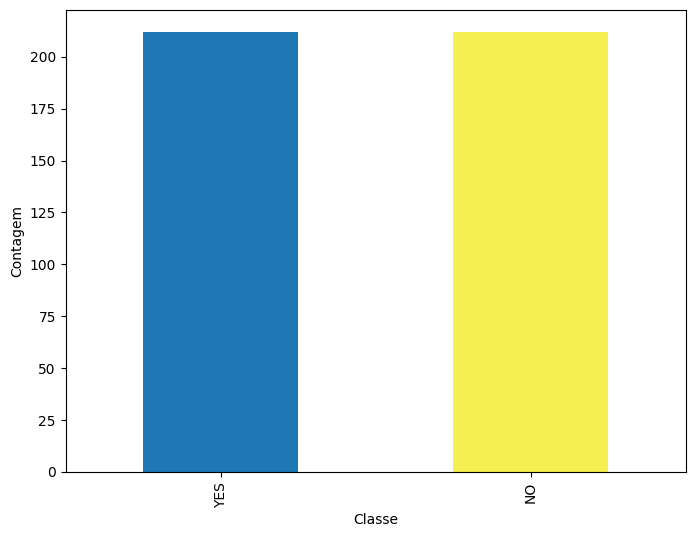

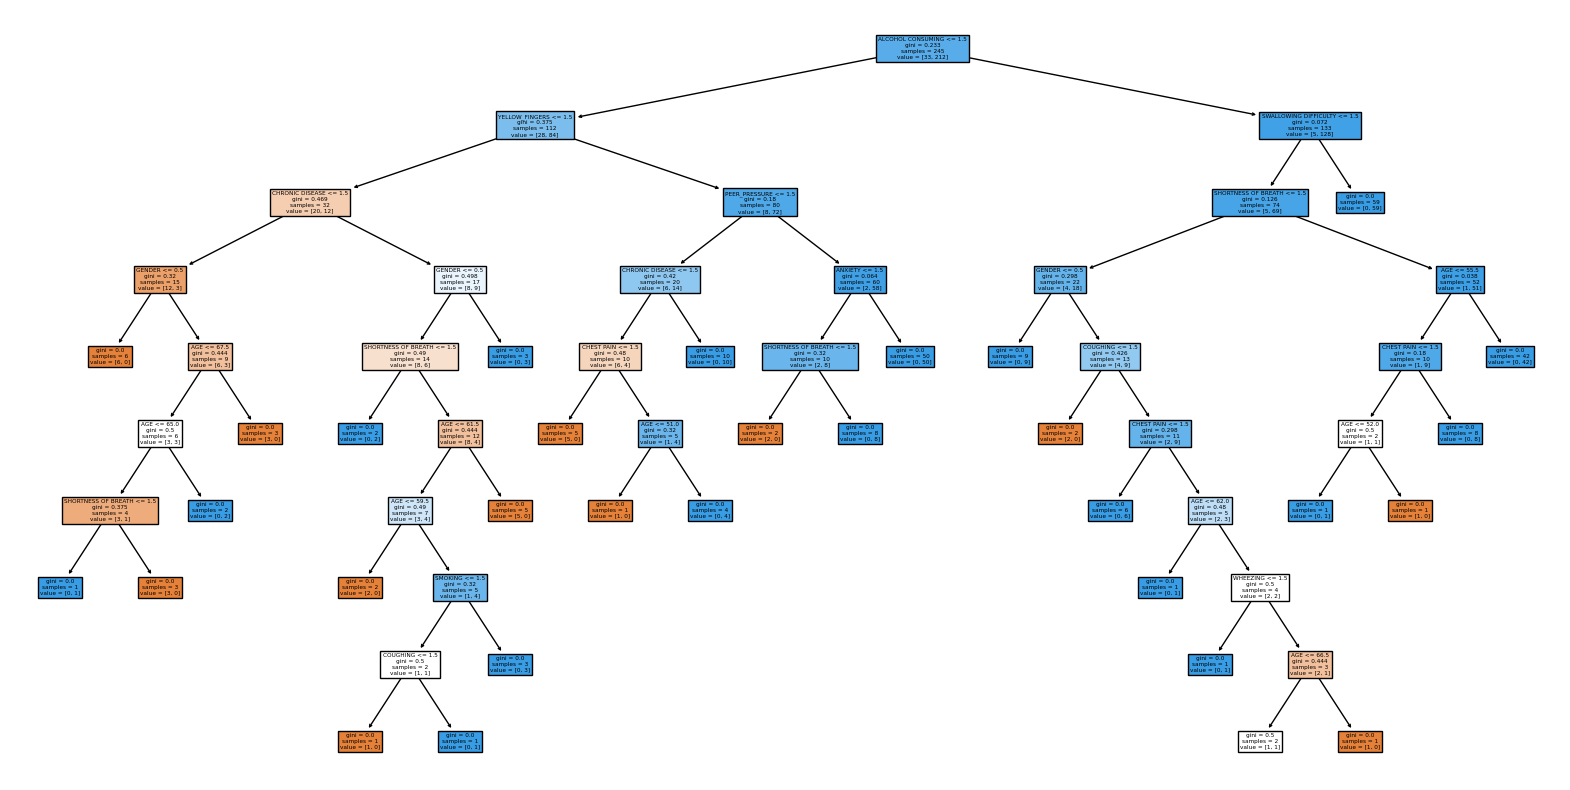

Feature Importance (Decision Tree):
GENDER: 0.060959293253825965
AGE: 0.1733767553946503
SMOKING: 0.010693242161926233
YELLOW_FINGERS: 0.22455808540045094
ANXIETY: 0.011881380179918025
PEER_PRESSURE: 0.038020416575737834
CHRONIC DISEASE: 0.0949811509676978
WHEEZING: 0.011881380179918044
ALCOHOL CONSUMING: 0.0977744426535165
COUGHING: 0.05820214556666146
SHORTNESS OF BREATH: 0.12548770685091337
SWALLOWING DIFFICULTY: 0.00534191295429159
CHEST PAIN: 0.0868420878604919

Feature Importance (Random Forest):
GENDER: 0.05020153388697635
AGE: 0.2098818988201278
SMOKING: 0.04691278010987769
YELLOW_FINGERS: 0.07529381725608794
ANXIETY: 0.06064229478343113
PEER_PRESSURE: 0.06488564145673943
CHRONIC DISEASE: 0.06753493603506633
WHEEZING: 0.05931427591417044
ALCOHOL CONSUMING: 0.11601480399637178
COUGHING: 0.05591200583276023
SHORTNESS OF BREATH: 0.06264703656511546
SWALLOWING DIFFICULTY: 0.07203963316687195
CHEST PAIN: 0.05871934217640332

Feature Importance (Neural Network - MLP):
GENDER: 0.11114

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn2pmml import PMMLPipeline, sklearn2pmml
from sklearn.tree import _tree

####################################################################################################################################################

# Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

####################################################################################################################################################

# Load the dataset
data = pd.read_csv('survey lung cancer.csv', encoding='latin1')

####################################################################################################################################################

# Preprocessing step

# Remove rows with missing values
data.dropna(inplace=True)

# Remove non-numeric columns
numeric_data = data.select_dtypes(include='number')

# Remove outliers using IQR
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Perform label encoding for 'GENDER' column
label_encoder = LabelEncoder()
data['GENDER'] = label_encoder.fit_transform(data['GENDER'])

# Feature selection
selected_columns = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 
                    'CHRONIC DISEASE', 'WHEEZING', 'ALCOHOL CONSUMING', 
                    'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN', 
                    'LUNG_CANCER']
data = data[selected_columns]

# Define features (X) and target variable (y)
X = data.drop(columns=['LUNG_CANCER']) 
y = data['LUNG_CANCER']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####################################################################################################################################################

# Balancing

# Perform balancing (oversampling and undersampling)
oversampler = RandomOverSampler(sampling_strategy='minority')
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = oversampler.fit_resample(X_train, y_train)
X_balanced, y_balanced = undersampler.fit_resample(X_over, y_over)

####################################################################################################################################################

# Algorithms before balancing

# Decision Tree before balancing
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_y_pred = dt_classifier.predict(X_test)

# Random Forest before balancing
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

# Neural Network before balancing
nn_classifier = MLPClassifier()
nn_classifier.fit(X_train, y_train)
nn_y_pred = nn_classifier.predict(X_test)

####################################################################################################################################################

# Calculating metrics

# Define a function to calculate accuracy
def custom_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Define a function to calculate precision for both classes
def custom_precision(y_true, y_pred, class_label):
    return precision_score(y_true, y_pred, pos_label=class_label)

# Define a function to calculate recall for both classes
def custom_recall(y_true, y_pred, class_label):
    return recall_score(y_true, y_pred, pos_label=class_label)

# Define a function to calculate the F1-score for both classes
def custom_f1(y_true, y_pred, class_label):
    return f1_score(y_true, y_pred, pos_label=class_label)

# Define the scorers for the custom metrics
scoring = {
    'accuracy': make_scorer(custom_accuracy),
    'precision_yes': make_scorer(custom_precision, class_label='YES'),
    'precision_no': make_scorer(custom_precision, class_label='NO'),
    'recall_yes': make_scorer(custom_recall, class_label='YES'),
    'recall_no': make_scorer(custom_recall, class_label='NO'),
    'f1_yes': make_scorer(custom_f1, class_label='YES'),
    'f1_no': make_scorer(custom_f1, class_label='NO')
}

####################################################################################################################################################

# Cross-validation for algorithms

# Cross-validation for Decision Tree
dt_cv_results = cross_validate(dt_classifier, X_balanced, y_balanced, cv=5, scoring=scoring)

# Cross-validation for Random Forest
rf_cv_results = cross_validate(rf_classifier, X_balanced, y_balanced, cv=5, scoring=scoring)

# Cross-validation for Neural Network
nn_cv_results = cross_validate(nn_classifier, X_balanced, y_balanced, cv=5, scoring=scoring)

####################################################################################################################################################

# Calculating metrics before and after cross-validation

# Calculate the means of the metrics during cross-validation
dt_cv_accuracy = dt_cv_results['test_accuracy'].mean()
dt_cv_precision_yes = dt_cv_results['test_precision_yes'].mean()
dt_cv_precision_no = dt_cv_results['test_precision_no'].mean()
dt_cv_recall_yes = dt_cv_results['test_recall_yes'].mean()
dt_cv_recall_no = dt_cv_results['test_recall_no'].mean()
dt_cv_f1_yes = dt_cv_results['test_f1_yes'].mean()
dt_cv_f1_no = dt_cv_results['test_f1_no'].mean()

rf_cv_accuracy = rf_cv_results['test_accuracy'].mean()
rf_cv_precision_yes = rf_cv_results['test_precision_yes'].mean()
rf_cv_precision_no = rf_cv_results['test_precision_no'].mean()
rf_cv_recall_yes = rf_cv_results['test_recall_yes'].mean()
rf_cv_recall_no = rf_cv_results['test_recall_no'].mean()
rf_cv_f1_yes = rf_cv_results['test_f1_yes'].mean()
rf_cv_f1_no = rf_cv_results['test_f1_no'].mean()

nn_cv_accuracy = nn_cv_results['test_accuracy'].mean()
nn_cv_precision_yes = nn_cv_results['test_precision_yes'].mean()
nn_cv_precision_no = nn_cv_results['test_precision_no'].mean()
nn_cv_recall_yes = nn_cv_results['test_recall_yes'].mean()
nn_cv_recall_no = nn_cv_results['test_recall_no'].mean()
nn_cv_f1_yes = nn_cv_results['test_f1_yes'].mean()
nn_cv_f1_no = nn_cv_results['test_f1_no'].mean()

# Create DataFrames to store the metrics
dt_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (YES)', 'Precision (NO)', 'Recall (YES)', 'Recall (NO)', 'F1-score (YES)', 'F1-score (NO)'],
    'Before CV': [accuracy_score(y_test, dt_y_pred)] + [0]*6,
    'After CV': [dt_cv_accuracy, dt_cv_precision_yes, dt_cv_precision_no, dt_cv_recall_yes, dt_cv_recall_no, dt_cv_f1_yes, dt_cv_f1_no]
})

rf_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (YES)', 'Precision (NO)', 'Recall (YES)', 'Recall (NO)', 'F1-score (YES)', 'F1-score (NO)'],
    'Before CV': [accuracy_score(y_test, rf_y_pred)] + [0]*6,
    'After CV': [rf_cv_accuracy, rf_cv_precision_yes, rf_cv_precision_no, rf_cv_recall_yes, rf_cv_recall_no, rf_cv_f1_yes, rf_cv_f1_no]
})

nn_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (YES)', 'Precision (NO)', 'Recall (YES)', 'Recall (NO)', 'F1-score (YES)', 'F1-score (NO)'],
    'Before CV': [accuracy_score(y_test, rf_y_pred)] + [0]*6,
    'After CV': [nn_cv_accuracy, nn_cv_precision_yes, nn_cv_precision_no, nn_cv_recall_yes, nn_cv_recall_no, nn_cv_f1_yes, nn_cv_f1_no]
})

# Display the DataFrames
print("Decision Tree Metrics:")
print(dt_metrics)

print("\nRandom Forest Metrics:")
print(rf_metrics)

print("\nNeural Network Metrics:")
print(nn_metrics)

####################################################################################################################################################

# Algorithms after balancing

# Decision Tree after balancing
dt_classifier_balanced = DecisionTreeClassifier()
dt_classifier_balanced.fit(X_balanced, y_balanced)
dt_y_pred_balanced = dt_classifier_balanced.predict(X_test)

# Random Forest after balancing
rf_classifier_balanced = RandomForestClassifier()
rf_classifier_balanced.fit(X_balanced, y_balanced)
rf_y_pred_balanced = rf_classifier_balanced.predict(X_test)

# Neural Network after balancing
nn_classifier_balanced = MLPClassifier(max_iter=1000)  # Increase the maximum number of iterations
nn_classifier_balanced.fit(X_balanced, y_balanced)
nn_y_pred_balanced = nn_classifier_balanced.predict(X_test)

####################################################################################################################################################

# Calculating metrics after balancing

# Calculate metrics for Decision Tree after balancing
dt_recall_yes = recall_score(y_test, dt_y_pred_balanced, pos_label='YES')
dt_recall_no = recall_score(y_test, dt_y_pred_balanced, pos_label='NO')
dt_f1_yes = f1_score(y_test, dt_y_pred_balanced, pos_label='YES')
dt_f1_no = f1_score(y_test, dt_y_pred_balanced, pos_label='NO')
dt_precision_yes = precision_score(y_test, dt_y_pred_balanced, pos_label='YES')
dt_precision_no = precision_score(y_test, dt_y_pred_balanced, pos_label='NO')

# Calculate metrics for Random Forest after balancing
rf_recall_yes = recall_score(y_test, rf_y_pred_balanced, pos_label='YES')
rf_recall_no = recall_score(y_test, rf_y_pred_balanced, pos_label='NO')
rf_f1_yes = f1_score(y_test, rf_y_pred_balanced, pos_label='YES')
rf_f1_no = f1_score(y_test, rf_y_pred_balanced, pos_label='NO')
rf_precision_yes = precision_score(y_test, rf_y_pred_balanced, pos_label='YES')
rf_precision_no = precision_score(y_test, rf_y_pred_balanced, pos_label='NO')

# Calculate metrics for Neural Network after balancing
nn_recall_yes = recall_score(y_test, nn_y_pred_balanced, pos_label='YES')
nn_recall_no = recall_score(y_test, nn_y_pred_balanced, pos_label='NO')
nn_f1_yes = f1_score(y_test, nn_y_pred_balanced, pos_label='YES')
nn_f1_no = f1_score(y_test, nn_y_pred_balanced, pos_label='NO')
nn_precision_yes = precision_score(y_test, nn_y_pred_balanced, pos_label='YES')
nn_precision_no = precision_score(y_test, nn_y_pred_balanced, pos_label='NO')

# Plotting the graphs
labels = ['YES', 'NO']
models = ['Decision Tree', 'Random Forest', 'Neural Network']
recalls_yes = [dt_recall_yes, rf_recall_yes, nn_recall_yes]
recalls_no = [dt_recall_no, rf_recall_no, nn_recall_no]
f1_yes = [dt_f1_yes, rf_f1_yes, nn_f1_yes]
f1_no = [dt_f1_no, rf_f1_no, nn_f1_no]
precisions_yes = [dt_precision_yes, rf_precision_yes, nn_precision_yes]
precisions_no = [dt_precision_no, rf_precision_no, nn_precision_no]

####################################################################################################################################################

# Plotting confusion matrix for algorithms

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix for Decision Tree
plot_confusion_matrix(y_test, dt_y_pred_balanced, 'Confusion Matrix - Decision Tree')

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf_y_pred_balanced, 'Confusion Matrix - Random Forest')

# Plot confusion matrix for Neural Network
plot_confusion_matrix(y_test, nn_y_pred_balanced, 'Confusion Matrix - Neural Network')

####################################################################################################################################################

# Plotting metrics graphs

# Plot for Precision
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(models))

for i, precision in enumerate(precisions_yes):
    plt.text(precision, i - bar_width/2, f'{precision:.2f}', ha='left', va='center', color='black')

for i, precision in enumerate(precisions_no):
    plt.text(precision, i + bar_width/2, f'{precision:.2f}', ha='left', va='center', color='black')

plt.barh([x - bar_width/2 for x in index], precisions_yes, bar_width, color='#57A140', label='YES')
plt.barh([x + bar_width/2 for x in index], precisions_no, bar_width, color='#E33625', label='NO')

plt.ylabel('Algorithm')
plt.xlabel('Precision')
plt.title('Precision', fontsize=16, pad=20)  
plt.yticks(index, models)
plt.yticks(index, models)
plt.legend()
plt.savefig('images\precision.png')
plt.show()

# Plot for Recall
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(models))

for i, recall in enumerate(recalls_yes):
    plt.text(recall, i - bar_width/2, f'{recall:.2f}', ha='left', va='center', color='black')

for i, recall in enumerate(recalls_no):
    plt.text(recall, i + bar_width/2, f'{recall:.2f}', ha='left', va='center', color='black')

plt.barh([x - bar_width/2 for x in index], recalls_yes, bar_width, color='#57A140', label='YES')
plt.barh([x + bar_width/2 for x in index], recalls_no, bar_width, color='#E33625', label='NO')

plt.ylabel('Algorithm')
plt.xlabel('Recall')
plt.title('Recall', fontsize=16, pad=20)
plt.yticks(index, models)
plt.legend()
plt.savefig('images\\recall.png')
plt.show()

# Plot for F1-score
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(models))

for i, f1 in enumerate(f1_yes):
    plt.text(f1, i - bar_width/2, f'{f1:.2f}', ha='left', va='center', color='black')

for i, f1 in enumerate(f1_no):
    plt.text(f1, i + bar_width/2, f'{f1:.2f}', ha='left', va='center', color='black')

plt.barh([x - bar_width/2 for x in index], f1_yes, bar_width, color='#57A140', label='YES')
plt.barh([x + bar_width/2 for x in index], f1_no, bar_width, color='#E33625', label='NO')

plt.ylabel('Algorithm')
plt.xlabel('F1-score')
plt.title('F1-score', fontsize=16, pad=20)
plt.yticks(index, models)
plt.legend()
plt.savefig('images\\f1-score.png')
plt.show()

####################################################################################################################################################

# Plotting graphs before and after balancing

# Lung cancer column count before balancing
contagem_antes = data['LUNG_CANCER'].value_counts()

# Lung cancer column count after balancing
contagem_depois = pd.Series(y_balanced).value_counts()

# Set bar colors
cor_yes = '#1F78B4'
cor_no = '#F5EF52'

# Create the first graph (before balancing)
plt.figure(figsize=(8, 6))
contagem_antes = contagem_antes.reindex(['YES', 'NO'], fill_value=0)  # Reorder the values
contagem_antes.plot(kind='bar', color=[cor_yes, cor_no])
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.grid(False)
plt.savefig('images\contagem_antes_balanceamento.png')
plt.show()

# Create the second graph (after balancing)
plt.figure(figsize=(8, 6))
contagem_depois = contagem_depois.reindex(['YES', 'NO'], fill_value=0)  # Reorder the values
contagem_depois.plot(kind='bar', color=[cor_yes, cor_no])
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.grid(False)
plt.savefig('images\contagem_depois_balanceamento.png')
plt.show()

####################################################################################################################################################

# Generating the importance of algorithm features

# Plotting  the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns)
plt.show()

# Feature importance for Decision Tree
feature_importance_dt = dt_classifier.feature_importances_
print("Feature Importance (Decision Tree):")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importance_dt[i]}")

# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Feature importance for Random Forest
feature_importance_rf = rf_classifier.feature_importances_
print("\nFeature Importance (Random Forest):")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importance_rf[i]}")

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50)) 
mlp_classifier.fit(X_train, y_train)

# Weights between the input layer and the first hidden layer
input_weights = mlp_classifier.coefs_[0]

# Calculating feature importance as the average of the weights for each feature
feature_importance_mlp = np.mean(np.abs(input_weights), axis=1)

print()

# Printing the importance of resources
print("Feature Importance (Neural Network - MLP):")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importance_mlp[i]}")

# Convert the trained MLP model to PMML
pipeline = PMMLPipeline([
    ("classifier", mlp_classifier)
])
pipeline.fit(X_train, y_train)

# Save the PMML model to a file
sklearn2pmml(pipeline, "model.pmml")

####################################################################################################################################################

# Decision Tree rules

def tree_to_rules(tree, feature_names, class_labels):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            coverage = tree_.n_node_samples[node]
            print(f"{name} <= {threshold} (Coverage: {coverage})")
            recurse(tree_.children_left[node])
            print(f"{name} > {threshold} (Coverage: {coverage})")
            recurse(tree_.children_right[node])
        else:
            class_idx = np.argmax(tree_.value[node])
            class_label = class_labels[class_idx]
            coverage = tree_.n_node_samples[node]
            print(f"Class: {class_label} (Coverage: {coverage})")

    recurse(0)

# Call the tree_to_rules function with your decision tree model, feature names, and class labels
print ()
print("Decision Tree rules:")
tree_to_rules(dt_classifier, X.columns, ['NO', 'YES'])
